In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
user = "aabounak"
password = "mysecretpassword"
host = "localhost"
port = "5433"
database = "piscineds"

def connect_to_postgres():
  return create_engine(
    url=f"postgresql://{user}:{password}@{host}:{port}/{database}"
  )

In [3]:
engine = connect_to_postgres()

In [4]:
with engine.connect() as connection:
  result = connection.execute(text('select * from customers limit 12000000'))
  data = result.fetchall()

columns_names = result.keys()
df = pd.DataFrame(data, columns=columns_names)
df.head()

,event_time,event_type,product_id,price,user_id,user_session,category_id,category_code,brand
0,2022-11-28 12:20:49+00:00,purchase,5741279,2.89,351481167,295a9f4c-bc91-4d08-9071-6f7131dec06f,1.487580e+18,None,irisk
1,2022-11-28 12:12:07+00:00,view,5741279,2.89,351481167,295a9f4c-bc91-4d08-9071-6f7131dec06f,1.487580e+18,None,irisk
2,2022-10-01 10:07:02+00:00,view,5741279,3.33,450664065,e67e53a6-16a9-48c9-bf55-53395dd0238b,1.487580e+18,None,irisk
3,2022-12-06 16:28:18+00:00,view,5741279,3.33,535478582,245b41d2-266c-4d02-97d1-4e06cb221793,1.487580e+18,None,irisk
4,2022-12-06 16:28:39+00:00,cart,5741279,3.33,535478582,245b41d2-266c-4d02-97d1-4e06cb221793,1.487580e+18,None,irisk


In [5]:

df.to_csv(r'./selected_data.csv')

In [6]:
sns.set_style("darkgrid")

### Exercise 00

<Axes: ylabel='count'>

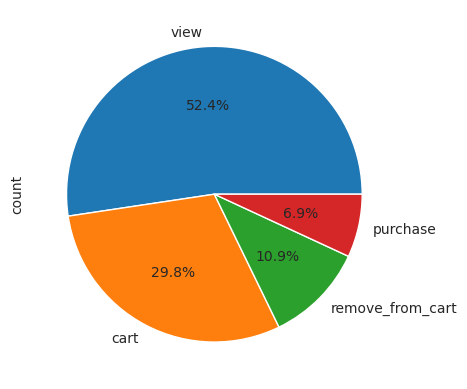

In [7]:
df['event_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

### Exercise 01

In [8]:
df['event_time'] = pd.to_datetime(df['event_time'])
purchase_data = df[(df['event_type'] == 'purchase')]

In [9]:
purchase_data = purchase_data.copy()

In [10]:
purchase_data['year'] = purchase_data['event_time'].dt.year
purchase_data.loc[:, 'month'] = purchase_data['event_time'].dt.month
purchase_data.loc[:, 'day'] = purchase_data['event_time'].dt.day

<Axes: xlabel='Date', ylabel='Number of customers'>

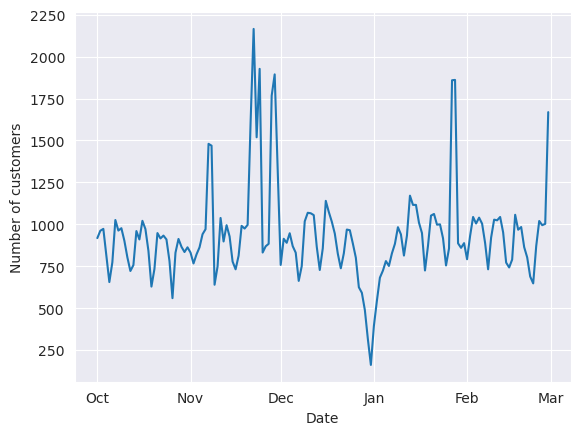

In [11]:
daily_customer_counts = purchase_data.groupby(['year', 'month', 'day'])['user_id'].nunique().reset_index()
daily_customer_counts['date'] = pd.to_datetime(daily_customer_counts[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

plt.ylabel('Number of customers')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

sns.lineplot(data=daily_customer_counts, x='date', y='user_id')

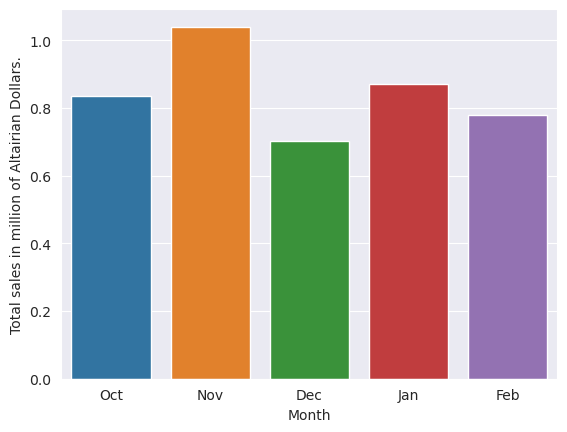

In [12]:
total_sales = purchase_data.groupby(['year', 'month'])['price'].sum().reset_index()
total_sales['date'] = pd.to_datetime(total_sales[['year', 'month']].astype(str).agg('-'.join, axis=1)).dt.strftime('%b')

total_sales['price_in_million'] = total_sales['price'] / 1000000

sns.barplot(data=total_sales, x='date', y='price_in_million')

plt.xlabel('Month')
plt.ylabel('Total sales in million of Altairian Dollars.')
plt.show()

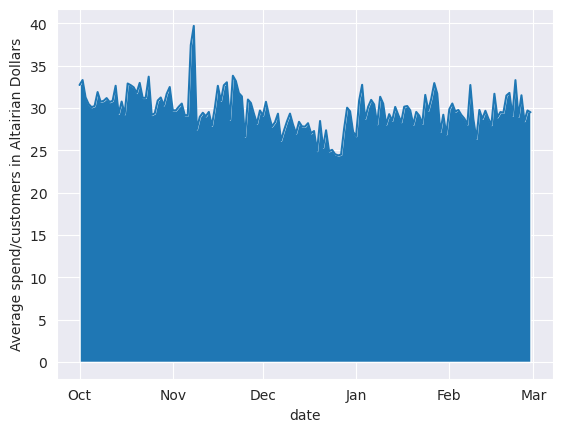

In [13]:
total_sales = purchase_data.groupby(['year', 'month', 'day'])['price'].sum().reset_index()
merged_data = pd.merge(total_sales, daily_customer_counts, on=['year', 'month', 'day'])
merged_data['average_spend_per_customer'] = merged_data['price'] / merged_data['user_id']
merged_data['date'] = pd.to_datetime(merged_data[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

sns.lineplot(data=merged_data, x='date', y='average_spend_per_customer')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.fill_between(merged_data['date'], merged_data['average_spend_per_customer'])
plt.ylabel('Average spend/customers in Altairian Dollars')
plt.show()


### Ex02

count    828240.000000
mean          5.105223
std           8.048786
min           0.060000
25%           1.730000
50%           3.170000
75%           5.560000
max         273.020000
Name: price, dtype: float64


<Axes: xlabel='price'>

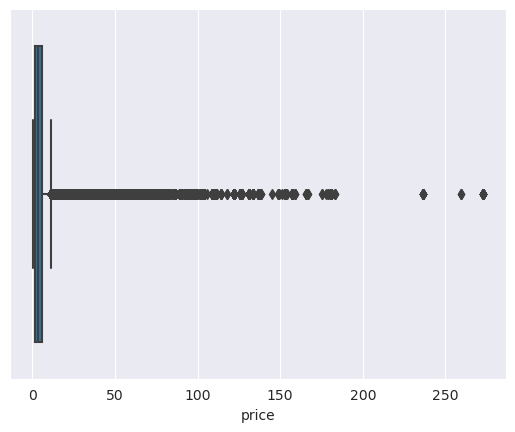

In [14]:
transformed_purchase_data = purchase_data.copy()
transformed_purchase_data['price'] = transformed_purchase_data['price'].astype(float)

print(transformed_purchase_data['price'].describe())
sns.boxplot(data=transformed_purchase_data, x='price')

<Axes: xlabel='price'>

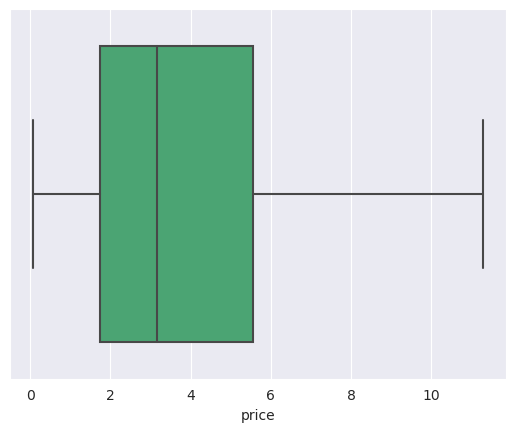

In [15]:
sns.boxplot(data=transformed_purchase_data, x='price', showfliers=False, color='mediumseagreen')

In [16]:
cart_df = df[(df['event_type'] == 'cart')]
cart_df = cart_df.copy()

In [17]:
# avg_basket = cart_df.groupby('user_id')['price'].mean().reset_index(name='avg_basket_price')
# avg_basket.head(10)
# sns.boxplot(data=avg_basket, x='avg_basket_price', showfliers=False)

### Ex03

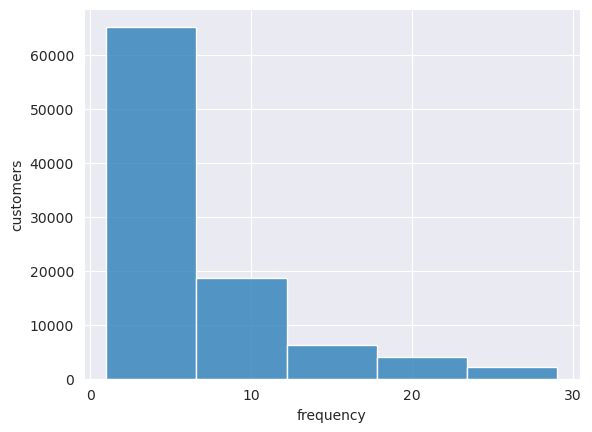

In [18]:
grouped_data = purchase_data.groupby('user_id').size().reset_index(name='purchases')
freq = grouped_data[grouped_data['purchases'] < 30].sort_values(by='purchases', ascending=False)

ax = sns.histplot(data=freq, x='purchases', bins=5)
ax.set(xlabel='frequency', ylabel='customers')
ax.set_xticks([0, 10, 20, 30])
plt.show()

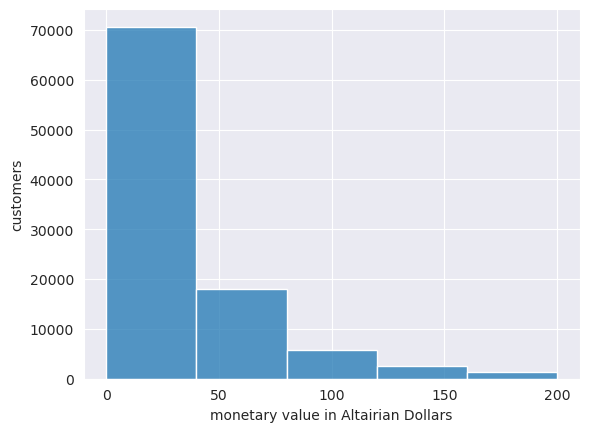

In [25]:
grouped_data = purchase_data.groupby('user_id')['price'].sum().reset_index(name='purchases')
monetary = grouped_data[grouped_data['purchases'] < 200].sort_values(by='purchases')

ax = sns.histplot(data=monetary, x='purchases', bins=5)
ax.set(xlabel='monetary value in Altairian Dollars', ylabel='customers')
ax.set_xticks([0, 50, 100, 150, 200])
plt.show()

### Ex04


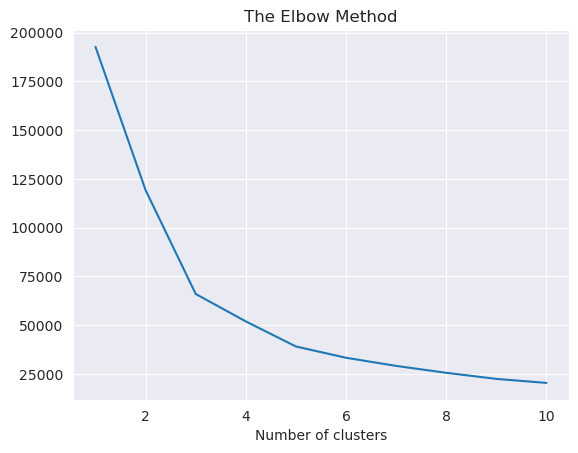

In [30]:
data = freq.copy()
scaled_data = StandardScaler().fit_transform(data)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
}

sse = []
n_cluster = range(1, 11)
for k in n_cluster:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_data)
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

plt.plot(n_cluster, sse)
plt.xlabel("Number of clusters")
plt.title("The Elbow Method")
plt.show()

### Ex05